# Bitcoin Data Analysis

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

## Load datasets: Interest (google trends) & Price
Two datasets are manually arranged in `data/DatasetPreparation.ipynb`:
- Google searches of term 'bitcoin' worldwide and daily since 2015: `google_trends_bitcoin_2015_2021_daily.csv`
- Price action hourly from Gemini: `Gemini_BTCUSD_2015_2021_hourly.csv`

In [84]:
# Halving dates
h2 = dt.datetime(2016,7,9,0,0,0)
h3 = dt.datetime(2020,5,11,0,0,0)

In [85]:
df_interest = pd.read_csv('data/google_trends_bitcoin_2015_2021_daily.csv',header=0)

In [86]:
df_interest['date'] = pd.to_datetime(df_interest['date'])

In [87]:
df_interest.set_index('date',inplace=True)

In [88]:
# Nomalization
max_interest = df_interest['bitcoin_searches_world'].max()
df_interest['bitcoin_searches_world'] = 100 * df_interest['bitcoin_searches_world'] / max_interest

In [89]:
df_interest.head()

,bitcoin_searches_world
date,
2015-01-01,1.117081
2015-01-02,1.311356
2015-01-03,1.359924
2015-01-04,1.602768
2015-01-05,1.505630


In [90]:
df_interest.describe()

,bitcoin_searches_world
count,2478.000000
mean,8.429307
std,9.738326
min,0.827235
25%,1.790998
50%,5.967269
75%,9.652057
max,100.000000


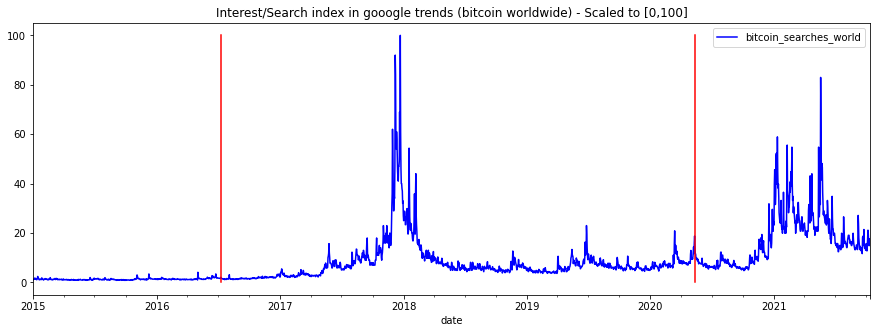

In [91]:
#%matplotlib ipympl
%matplotlib inline
#df_interest.plot(x='date',y='bitcoin_searches_world',figsize=(15,5),color='r')
df_interest.plot(y='bitcoin_searches_world',figsize=(15,5),color='b')
plt.plot([h2,h2],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.plot([h3,h3],[0,df_interest['bitcoin_searches_world'].max()],color='r')
plt.title('Interest/Search index in gooogle trends (bitcoin worldwide) - Scaled to [0,100]')
plt.show()

In [92]:
df_price = pd.read_csv('data/Gemini_BTCUSD_2015_2021_hourly.csv',header=0)

In [93]:
df_price['Date'] = pd.to_datetime(df_price['Date'])

In [94]:
df_price.set_index('Date',inplace=True)

In [95]:
df_price.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632


In [96]:
df_price.describe()

,Open,High,Low,Close,Volume
count,51353.000000,51353.000000,51353.000000,51353.000000,53052.000000
mean,11329.579032,11396.564251,11257.293497,11330.764995,136.272012
std,14931.920498,15025.617945,14830.217792,14933.354612,267.161354
min,0.000000,243.600000,0.000000,243.600000,0.000000
25%,1186.010000,1188.990000,1183.470000,1186.100000,18.450712
50%,6858.430000,6893.000000,6824.610000,6858.710000,56.080521
75%,10587.790000,10636.850000,10525.410000,10587.930000,145.476383
max,66892.380000,66994.720000,66357.600000,66892.380000,8526.751048


In [97]:
%matplotlib ipympl
df_price.plot(y='Close',figsize=(15,5),color='b')
ax = plt.gca()
ax.plot([h2,h2],[0,df_price['Close'].max()],color='r')
ax.plot([h3,h3],[0,df_price['Close'].max()],color='r')
plt.title('Closing price USD/BTC')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 1. Preliminary Analysis
Halving epochs are analyzed starting from the halving date until the ATH.
The number of hours at each price level is computed and ploted.

In [98]:
# Halving 2016: 2016-07-09
# ATH 2017: 2017-12-17
#start = dt.datetime(2016,7,9,0,0,0)
#end = dt.datetime(2017,12,17,0,0,0)
#end = dt.datetime(2017,9,15,0,0,0)
# Halving 2020: 2020-05-11
# ATH 2021: ?
start = dt.datetime(2020,5,11,0,0,0)
end = dt.datetime(2021,10,10,0,0,0)
if (df_price.index[-1] < end or df_interest.index[-1] < end):
    end = min([df_price.index[-1],df_interest.index[-1]])
duration_days = (end-start).days

In [99]:
duration_days

517

In [100]:
df_price.loc[start:end].shape

(12409, 5)

In [101]:
df_price['Low'].loc[start:end].plot(figsize=(15,5))

<AxesSubplot:title={'center':'Closing price USD/BTC'}, xlabel='Date'>

In [102]:
df_window = df_price.loc[start:end]
n = 100
max_price = df_window['Low'].max()
min_price = df_window['Low'].min()
ref_price = df_window['Low'].iloc[0]
print('min_price = {}, ref_price = {}, max_price = {}'.format(min_price, ref_price, max_price))

min_price = 8200.0, ref_price = 8709.62, max_price = 64311.25


In [103]:
df_price['Factor'] = df_price['Low']/ref_price
df_window = df_price.loc[start:end]
max_factor = df_window['Factor'].max()
min_factor = df_window['Factor'].min()
step_factor = (max_factor - min_factor) / (n-1)
step_price = (max_price - min_price) / (n-1)
print('min_factor = {}, max_factor = {}, step_factor = {}, step_price = {}'.format(min_factor, max_factor, step_factor, step_price))

min_factor = 0.9414876883262415, max_factor = 7.383932938520854, step_factor = 0.06507520454742033, step_price = 566.780303030303


In [104]:
price_bins = np.zeros(n)
for i in range(df_window.shape[0]):
    if not (np.isnan(df_window.iloc[i]['Low'])):
        b = np.int(np.floor((df_window.iloc[i]['Low'] - min_price) / step_price))
        price_bins[b] = price_bins[b] + 1

In [105]:
price_bins

array([ 55., 873., 792., 305., 605., 631., 430.,  36., 173., 156.,  20.,
        25., 118.,  68.,  62.,  52.,  74., 143., 170., 224.,   5.,   5.,
         5.,   5.,   9.,  67.,  81.,  46.,  11.,  12.,   5.,  14.,  46.,
        17.,  18.,  12.,  38.,  50.,  22.,  50., 100., 180., 178., 176.,
       207., 221., 195., 105., 192., 143., 164., 141., 134., 132., 113.,
       128.,  80.,  51.,  58.,  65.,  77.,  90.,  82.,  88., 120., 106.,
       152., 156., 214., 234., 169., 205., 142., 128., 100.,  55.,  69.,
        40.,  39.,  60., 111., 140., 132., 126., 127., 134., 140., 155.,
       107., 105.,  66.,  39.,  35.,  17.,  11.,  27.,  28.,  10.,   3.,
         1.])

In [106]:
df_window['Low'].hist(bins=100,figsize=(15,5))
plt.xlabel('USD/BTC')
plt.ylabel('Number of hours')

Text(92.125, 0.5, 'Number of hours')

In [107]:
df_window['Factor'].hist(bins=100,figsize=(15,5))
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

Text(92.125, 0.5, 'Number of hours')

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Number of hours')

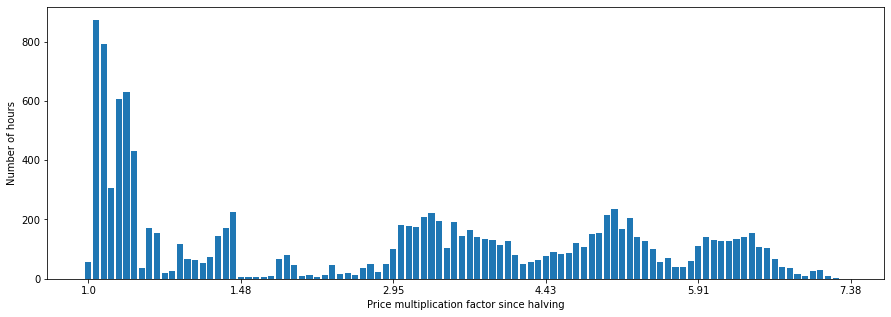

In [108]:
#%matplotlib ipympl
%matplotlib inline
plt.figure(figsize=(15,5))
#plt.bar(x=np.linspace(min_price,max_price,n),height=price_bins)
plt.bar(x=range(n),height=price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours')

In [109]:
acc_price_bins = np.zeros(n)
l = range(n)
for i in l[::-1]:
    acc_price_bins[i] = price_bins[i:-1].sum()

In [110]:
x = np.linspace(min_price,max_price,n)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0, 0.5, 'Number of hours in factor range or smaller')

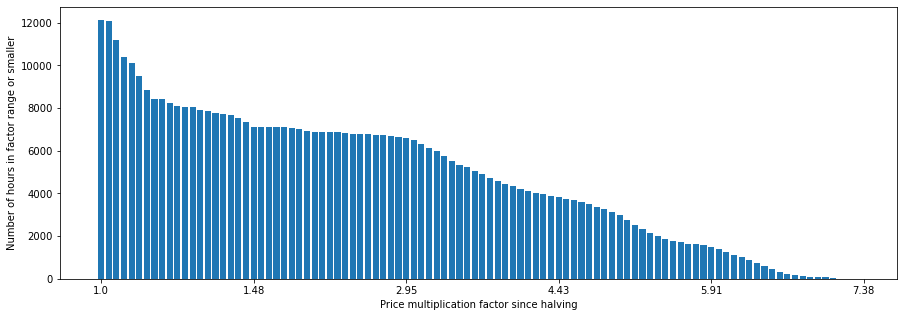

In [111]:
plt.figure(figsize=(15,5))
plt.bar(x=range(n),height=acc_price_bins)
ax = plt.gca()
ticks = ax.get_xticks()
new_ticks = np.round(max_factor*ticks/100,decimals=2)
new_ticks[1] = 1
ax.set_xticklabels(new_ticks)
plt.xlabel('Price multiplication factor since halving')
plt.ylabel('Number of hours in factor range or smaller')

In [112]:
acc_price_bins

array([1.2132e+04, 1.2077e+04, 1.1204e+04, 1.0412e+04, 1.0107e+04,
       9.5020e+03, 8.8710e+03, 8.4410e+03, 8.4050e+03, 8.2320e+03,
       8.0760e+03, 8.0560e+03, 8.0310e+03, 7.9130e+03, 7.8450e+03,
       7.7830e+03, 7.7310e+03, 7.6570e+03, 7.5140e+03, 7.3440e+03,
       7.1200e+03, 7.1150e+03, 7.1100e+03, 7.1050e+03, 7.1000e+03,
       7.0910e+03, 7.0240e+03, 6.9430e+03, 6.8970e+03, 6.8860e+03,
       6.8740e+03, 6.8690e+03, 6.8550e+03, 6.8090e+03, 6.7920e+03,
       6.7740e+03, 6.7620e+03, 6.7240e+03, 6.6740e+03, 6.6520e+03,
       6.6020e+03, 6.5020e+03, 6.3220e+03, 6.1440e+03, 5.9680e+03,
       5.7610e+03, 5.5400e+03, 5.3450e+03, 5.2400e+03, 5.0480e+03,
       4.9050e+03, 4.7410e+03, 4.6000e+03, 4.4660e+03, 4.3340e+03,
       4.2210e+03, 4.0930e+03, 4.0130e+03, 3.9620e+03, 3.9040e+03,
       3.8390e+03, 3.7620e+03, 3.6720e+03, 3.5900e+03, 3.5020e+03,
       3.3820e+03, 3.2760e+03, 3.1240e+03, 2.9680e+03, 2.7540e+03,
       2.5200e+03, 2.3510e+03, 2.1460e+03, 2.0040e+03, 1.8760e

In [113]:
acc_price_bins[80:-1]

array([1513., 1402., 1262., 1130., 1004.,  877.,  743.,  603.,  448.,
        341.,  236.,  170.,  131.,   96.,   79.,   68.,   41.,   13.,
          3.])

In [114]:
# Arrange a custom dataframe
df_tmp = pd.DataFrame()
df_tmp['close'] = df_price['Close'].resample(rule='D').last().loc[start:end]
df_tmp['factor'] = df_price['Factor'].resample(rule='D').last().loc[start:end]
df_tmp['interest'] = df_interest['bitcoin_searches_world'].loc[start:end]
df_tmp['date'] = df_interest.loc[start:end].index
df_tmp['day'] = range((end-start).days+1)

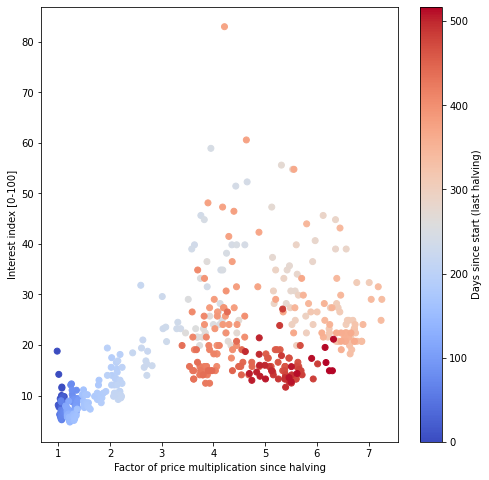

In [115]:
plt.figure(figsize=(8,8))
#df1.plot.scatter(x='A',y='B',c='C',cmap='coolwarm')
#https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
plt.scatter(x=df_tmp['factor'],y=df_tmp['interest'],c=df_tmp['day'],cmap='coolwarm')
plt.xlabel('Factor of price multiplication since halving')
plt.ylabel('Interest index [0-100]')
cbar = plt.colorbar()
cbar.set_label('Days since start (last halving)')

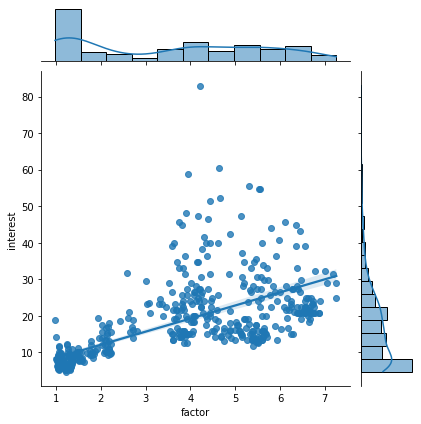

In [116]:
sns.jointplot(x='factor',y='interest',data=df_tmp,kind='reg')

## 2. Low and Upper Baselines

In [117]:
x = np.array([2, 3, 4, 5])
degree = 5
X = np.vander(x, N=degree, increasing=True)

In [118]:
X_pinv = np.linalg.pinv(X)

In [119]:
df_price['Close'].loc[h2]

661.99